In [1]:
# First, import libraries to be used and modify dataset as in S13 T01 P1

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn import svm

import xgboost as xgb


In [2]:
# Modify dataset as in S13 T01 P1; for more detailed information, check that same notebook

dades = pd.read_csv("../Sprint 11/DelayedFlights.csv")

dades.drop(columns=["Unnamed: 0", "Year", "FlightNum", "TailNum", "Cancelled", "CancellationCode"], inplace=True)

dades["ArrDelay"].fillna(dades["DepDelay"], inplace = True)

delay = dades["CRSElapsedTime"] + dades["DepDelay"]

dades["ActualElapsedTime"].fillna(delay, inplace = True)

dades["TaxiIn"].fillna(dades["TaxiIn"].mean(), inplace=True)

dades["TaxiOut"].fillna(dades["TaxiOut"].mean(), inplace=True)

dades["is_delay"] = dades["ArrDelay"].apply(lambda x: 0 if x==0 else 1)

scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(dades[["is_delay", "DepDelay", "Distance", "TaxiIn", "TaxiOut"]])

scaled_df = pd.DataFrame(scaled_df, columns = ["is_delay", "DepDelay", "Distance", "TaxiIn", "TaxiOut"])

_________________________________________________________________________________________________________
#########################################################################################################
_________________________________________________________________________________________________________

### Exercise 3

Train the algorithms using hyperparameter tuning.

In [3]:
# Logistic Regression

y = scaled_df["is_delay"]
X = scaled_df[["DepDelay", "Distance", "TaxiIn", "TaxiOut"]]

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y, random_state = 98, stratify= scaled_df["is_delay"])

In [4]:
# We change class weight to balanced and max iterations to 200
# Fit and predict

logistic = LogisticRegression(class_weight="balanced", max_iter=200)

logistic.fit(X_train_log, y_train_log)

y_pred_log = logistic.predict(X_test_log)

In [5]:
# Calculating performance scores: accuracy score, confusion matrix, F1 score and AUC score

print(metrics.accuracy_score(y_test_log, y_pred_log))

print(metrics.confusion_matrix(y_test_log, y_pred_log))

print(metrics.f1_score(y_test_log, y_pred_log))

y_pred_prob_log = logistic.predict_proba(X_test_log)[:, 1]

print(metrics.roc_auc_score(y_test_log, y_pred_prob_log))

# Even if the indicators are quite bad in comparison with the models before modifications, we can see that after
# balancing class weights we predict the big majority of target class instances. However, in the process we also
# misclasify around a third of the majority class instances. In absolute numbers, that represents a very large 
# amount.

0.6678741816229167
[[  6135    625]
 [160187 317243]]
0.7977965492180289
0.8423236382928962


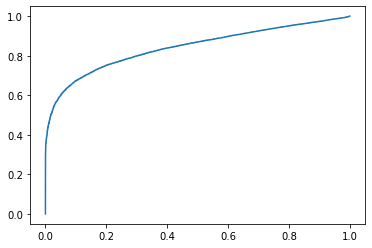

In [6]:
# ROC curve: as specificity augments, sensibility descends

# We want to maximise Specificity: when the actual value is negative (no delay), how often is the prediction 
# correct?

fpr, tpr, thresholds = metrics.roc_curve(y_test_log, y_pred_prob_log)

plt.plot(fpr, tpr)

In [7]:
# We will now change threshold levels to further improve prediction power:

from sklearn.preprocessing import binarize

# Transform into 2D arrays to be able to analyse:

y_pred_prob_log = y_pred_prob_log.reshape(-1, 1)

y_test_log = np.array(y_test_log).reshape(-1, 1)

# Change threshold:

y_pred_class = binarize(y_pred_prob_log, 0.55)

# What we are doing here is taking the (now 2-D array of) prediction coefficients for 1 (delayed flight); by using
# binarize we modify the probability threshold (0.55 instead of the logistic regression 0.5) that classifies 
# instances into whether they are expected to be predicted delays or non-delays

print(metrics.confusion_matrix(y_test_log, y_pred_class))

# As we see and we could logically deduct, given the very small amount of not delayed flights, a small increase 
# in the threshold level to detect a couple hundred more delay cases has an enormous impact (20k misclassified
# delayed flights more than pre-modification) on how well we detect the majority variable


/Users/pau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.55 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


[[  6331    429]
 [179352 298078]]


In [8]:
####################################################################################################
#------------------------------------ IMPORTANT ---------------------------------------------------#
####################################################################################################

# In the end, the tradeoff between specificity and sensibility has a lot to do with the business incentives of 
# each case. If this were a real situation, how costly is it to misclassify flights as delayed? What about the
# other way around? 

# By tuning our models data scientists have a lot of power in predicting future outcomes and, as a consequence, 
# business decisions

_________________________________________________________________________________________________________
#########################################################################################################
_________________________________________________________________________________________________________

In [9]:
# Support Vector Machine

# Resampling and reducing sample size

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, train_size=75000, test_size=25000, random_state = 13, stratify= scaled_df["is_delay"])

In [10]:
# Model fit:

# Modifications on kernel (poly instead of linear), iterations limit, and class weights

vector = svm.SVC(kernel='poly', degree=2, max_iter=800, class_weight="balanced", probability=True, random_state=133)

vector.fit(X_train_svm, y_train_svm)


/Users/pau/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


SVC(class_weight='balanced', degree=2, kernel='poly', max_iter=800,
    probability=True, random_state=133)

In [11]:
# Model predictions:

y_pred_svm = vector.predict(X_test_svm)

In [12]:
# Performance metrics:

print("Accuracy:", metrics.accuracy_score(y_test_svm, y_pred_svm))

print("Confusion matrix:", metrics.confusion_matrix(y_test_svm, y_pred_svm))

print("F1:", metrics.f1_score(y_test_svm, y_pred_svm))

y_pred_prob_svm = logistic.predict_proba(X_test_svm)[:, 1]

print("AUC", metrics.roc_auc_score(y_test_svm, y_pred_prob_svm))

Accuracy: 0.02956
Confusion matrix: [[  349     0]
 [24261   390]]
F1: 0.031148915778123874
AUC 0.8487115664766094


In [13]:
# A combination of different hyperparameters have been tuned to find the best performance, but the same constraints
# still remain. Either the performance sees extremely high values (due to classifying all majority class instances)
# or the classification of minority instances takes a big toll in terms of false negatives and, as a consequence,
# performance metrics

_________________________________________________________________________________________________________
#########################################################################################################
_________________________________________________________________________________________________________

In [14]:
# Resampling

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, train_size=75000, test_size=25000, 
                                                                random_state = 400, stratify= scaled_df["is_delay"])

# XGradient Boost:

# Adjusting now for ETA, gamma and max depth

xclassif = xgb.XGBClassifier(eta=0.25, gamma = 1, max_depth = 8, random_state=9)

# Fit the model

xclassif.fit(X_train_xgb, y_train_xgb)



/Users/pau/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:29:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.25, gamma=1,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=9,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
# Model prediction

y_pred_xgb = xclassif.predict(X_test_xgb)


In [16]:
# Printing performance scores:

print(metrics.accuracy_score(y_test_xgb, y_pred_xgb))

print(metrics.confusion_matrix(y_test_xgb, y_pred_xgb))

print(metrics.f1_score(y_test_xgb, y_pred_xgb))

y_pred_prob_xgb = xclassif.predict_proba(X_test_xgb)[:, 1] 

print(metrics.roc_auc_score(y_test_xgb, y_pred_prob_xgb))


0.98596
[[    0   349]
 [    2 24649]]
0.9929303712058651
0.8358285679547804


In [17]:
# Some manual hyperparameter tuning has been tried but it has not been able to predict perfectly. This might be due
# to bad indepedent variable selection, a small amount of minority class instances, wrong model/alogrithm choice, 
# mislead hyperparameter tuning or even no relationship at all. Hopefully in the future with algorithms such as 
# GridSearch it will be easier to find the most appropriate model and characteristics

In [18]:
# So far no algorithm has been able to create a good classification model: one that has high performance metrics
# and yet classifies correctly the minority class (ArrDelay)

# In that regard, the best models that combine those extremes are logistic regressions with balanced weights and
# changing thresholds, which is surprising given how ML argorithms are supposed to be more sophisticate and accurate

_________________________________________________________________________________________________________
#########################################################################################################
_________________________________________________________________________________________________________

### Exercise 4

Compare their performance using the train/test approach or cross-validation.

In [19]:
# All models have taken the train/test approximation of training and fitting

In [20]:
# Due to file size concerns, this exercise continues at S13 T01 P3